Data Analysis

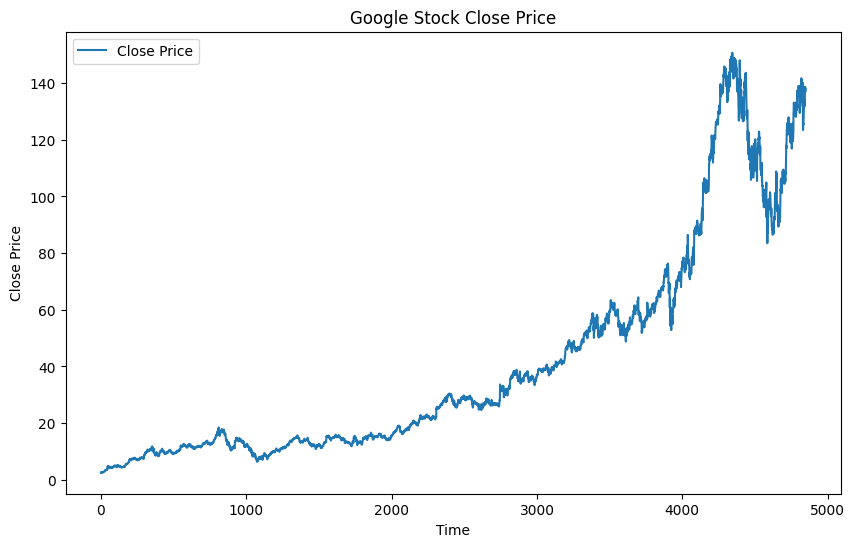

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

# Reading the data from CSV file
google_stock = pd.read_csv("GOOG.csv")

# Selecting the 'Close' column
google_stock_close = google_stock['Close']

# Converting the values to a time series data
google_stock_close = pd.Series(google_stock_close)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(google_stock_close, label='Close Price')
plt.title('Google Stock Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

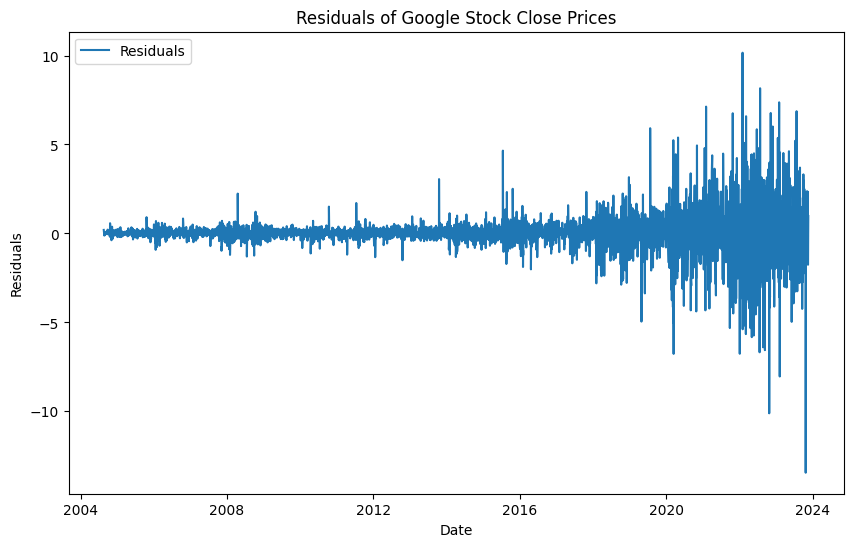

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Correct the date format
google_stock['Date'] = pd.to_datetime(google_stock['Date'])

# Remove NaN values
google_stock = google_stock.dropna()

# Extract the 'Close' prices
prices = google_stock['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Create a time series of dates for the residuals
dates = google_stock['Date'].iloc[1:]

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.plot(dates, residuals, label='Residuals')
plt.title('Residuals of Google Stock Close Prices')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

1 Layer Simple RNN Model - Baseline Model

30/30 [==============================] - 0s 2ms/step
Train RMSE: 0.03
Test RMSE: 0.28
Train MAE: 0.02
Test MAE: 0.17
Train MAPE: 0.16%
Test MAPE: 0.17%


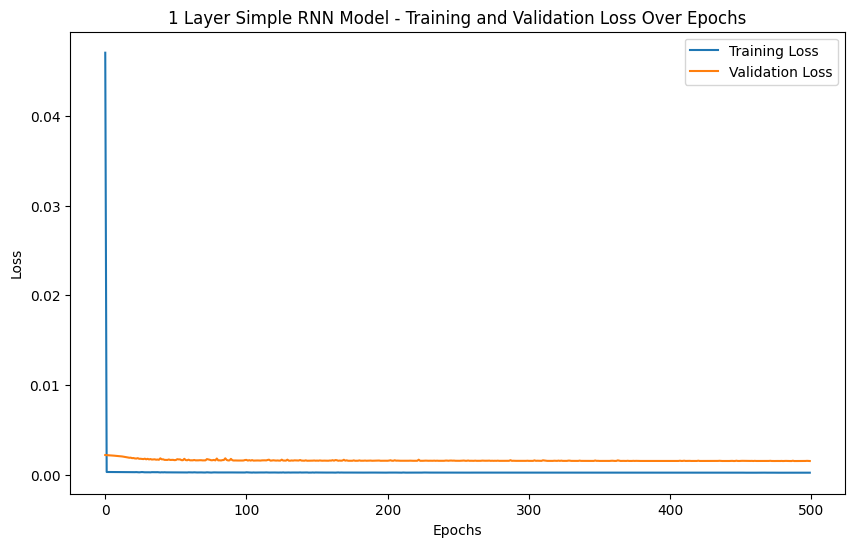

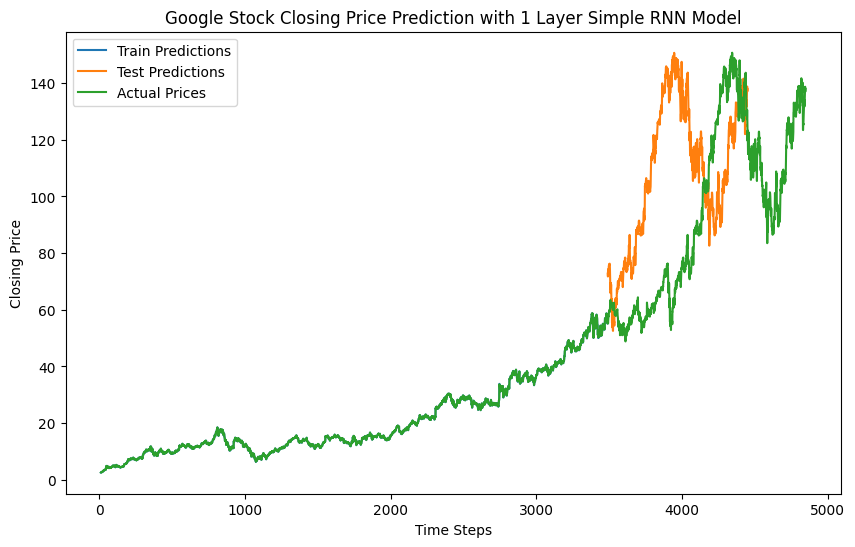

In [130]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building 1 Layer Simple RNN Model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('1 Layer Simple RNN Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions and actual prices
plt.figure(figsize=(10, 6))
plt.title('Google Stock Closing Price Prediction with 1 Layer Simple RNN Model')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')
test_pred_range = np.arange(len(train_predictions) + time_steps, len(prices))
plt.plot(test_pred_range[:len(test_predictions)], test_predictions, label='Test Predictions')
actual_price_range = np.arange(time_steps, len(prices))
plt.plot(actual_price_range, prices[time_steps:], label='Actual Prices')
plt.legend()
plt.show()

2 Layer Simple RNN Model

30/30 [==============================] - 0s 1ms/step
Train RMSE: 0.04
Test RMSE: 0.11
Train MAE: 0.04
Test MAE: 0.07
Train MAPE: 0.25%
Test MAPE: 0.07%


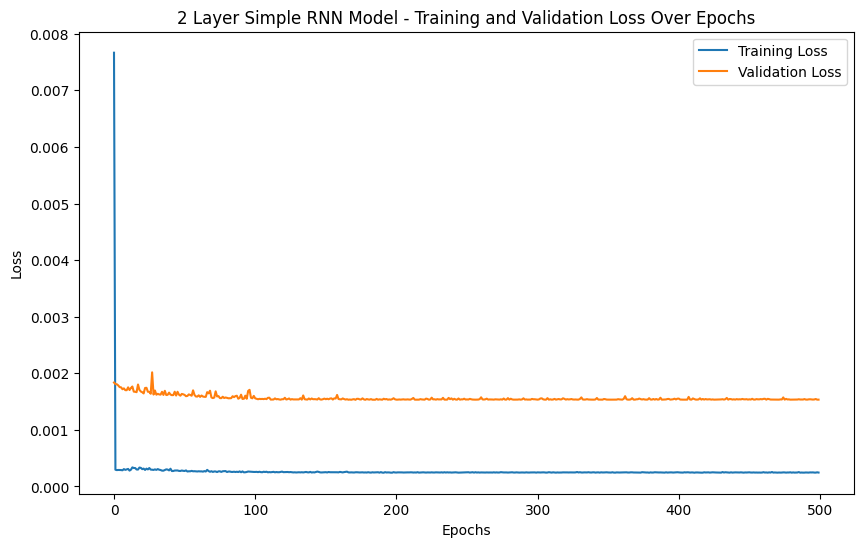

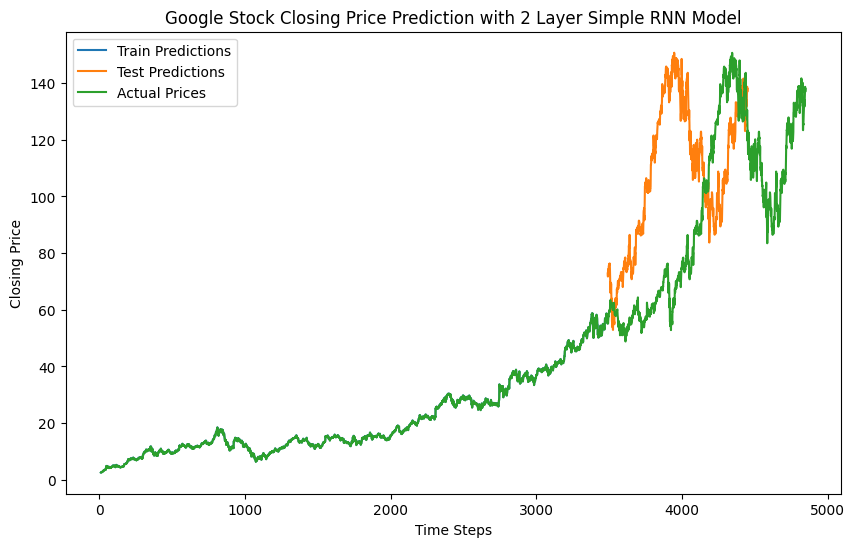

In [131]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building 2 Layer Simple RNN Model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(SimpleRNN(units=50, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('2 Layer Simple RNN Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions and actual prices
plt.figure(figsize=(10, 6))
plt.title('Google Stock Closing Price Prediction with 2 Layer Simple RNN Model')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')
test_pred_range = np.arange(len(train_predictions) + time_steps, len(prices))
plt.plot(test_pred_range[:len(test_predictions)], test_predictions, label='Test Predictions')
actual_price_range = np.arange(time_steps, len(prices))
plt.plot(actual_price_range, prices[time_steps:], label='Actual Prices')
plt.legend()
plt.show()

1 Layer LSTM Model

30/30 [==============================] - 0s 2ms/step
Train RMSE: 0.05
Test RMSE: 0.05
Train MAE: 0.05
Test MAE: 0.04
Train MAPE: 0.33%
Test MAPE: 0.04%


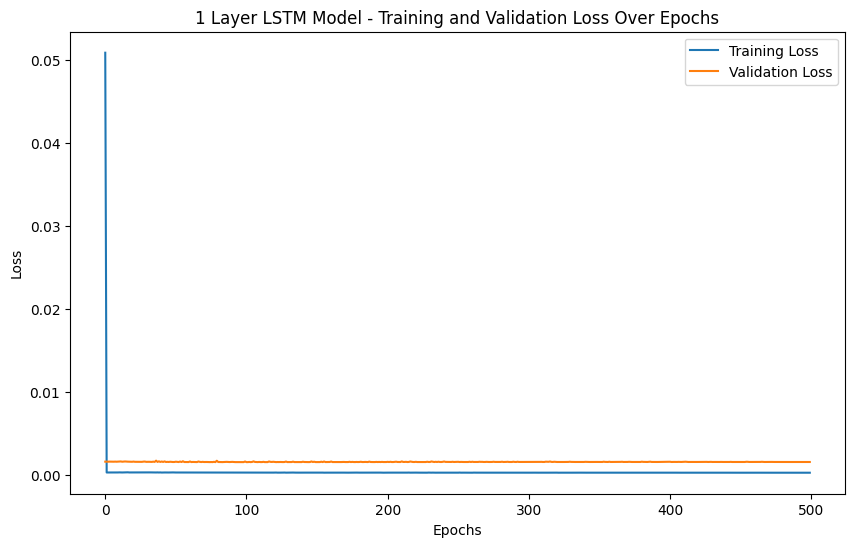

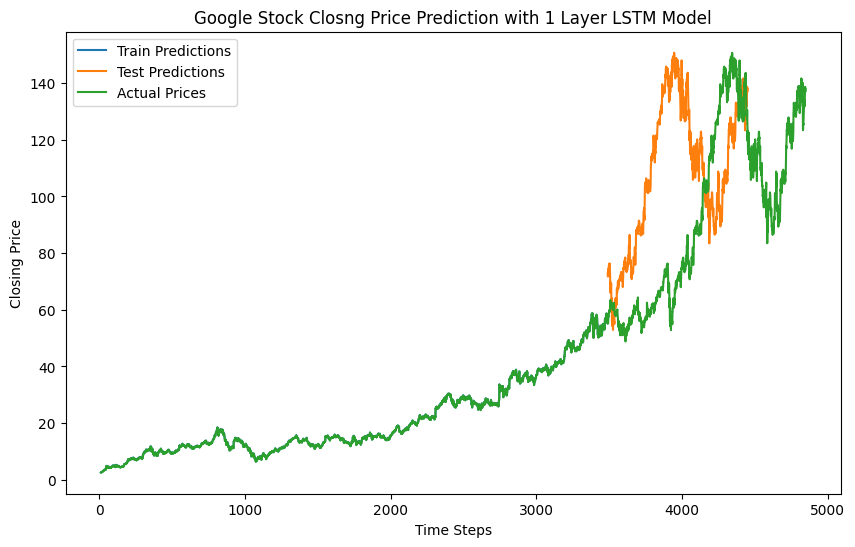

In [132]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building the 1 Layer LSTM Model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('1 Layer LSTM Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions and actual prices
plt.figure(figsize=(10, 6))
plt.title('Google Stock Closng Price Prediction with 1 Layer LSTM Model')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')
test_pred_range = np.arange(len(train_predictions) + time_steps, len(prices))
plt.plot(test_pred_range[:len(test_predictions)], test_predictions, label='Test Predictions')
actual_price_range = np.arange(time_steps, len(prices))
plt.plot(actual_price_range, prices[time_steps:], label='Actual Prices')
plt.legend()
plt.show()

2 Layer LSTM Model

30/30 [==============================] - 0s 2ms/step
Train RMSE: 0.07
Test RMSE: 0.07
Train MAE: 0.07
Test MAE: 0.07
Train MAPE: 0.53%
Test MAPE: 0.07%


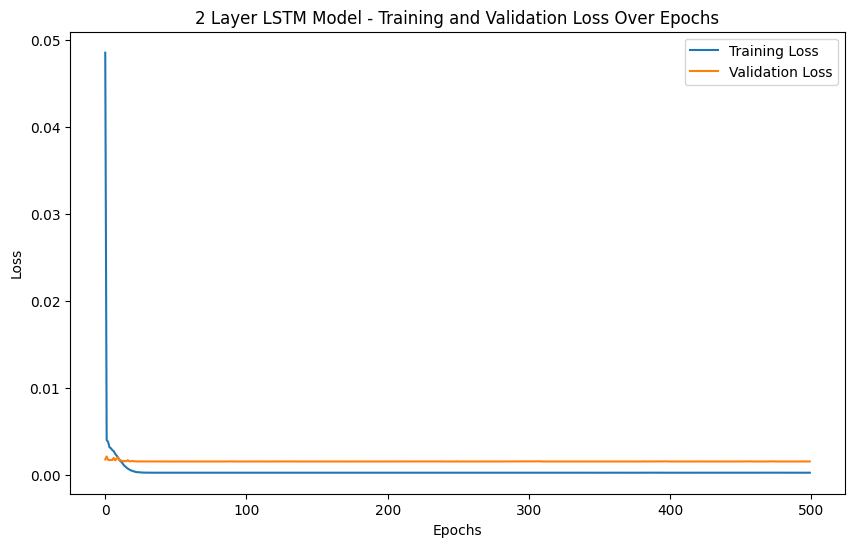

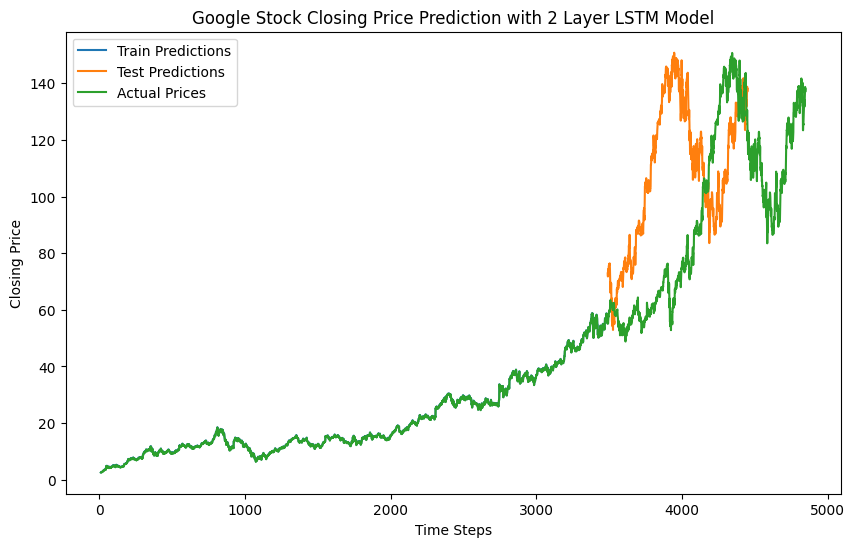

In [133]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building 2 Layer LSTM Model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('2 Layer LSTM Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions and actual prices
plt.figure(figsize=(10, 6))
plt.title('Google Stock Closing Price Prediction with 2 Layer LSTM Model')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')
test_pred_range = np.arange(len(train_predictions) + time_steps, len(prices))
plt.plot(test_pred_range[:len(test_predictions)], test_predictions, label='Test Predictions')
actual_price_range = np.arange(time_steps, len(prices))
plt.plot(actual_price_range, prices[time_steps:], label='Actual Prices')
plt.legend()
plt.show()

3 Layer LSTM Model

30/30 [==============================] - 0s 2ms/step
Train RMSE: 0.02
Test RMSE: 0.02
Train MAE: 0.02
Test MAE: 0.02
Train MAPE: 0.17%
Test MAPE: 0.02%


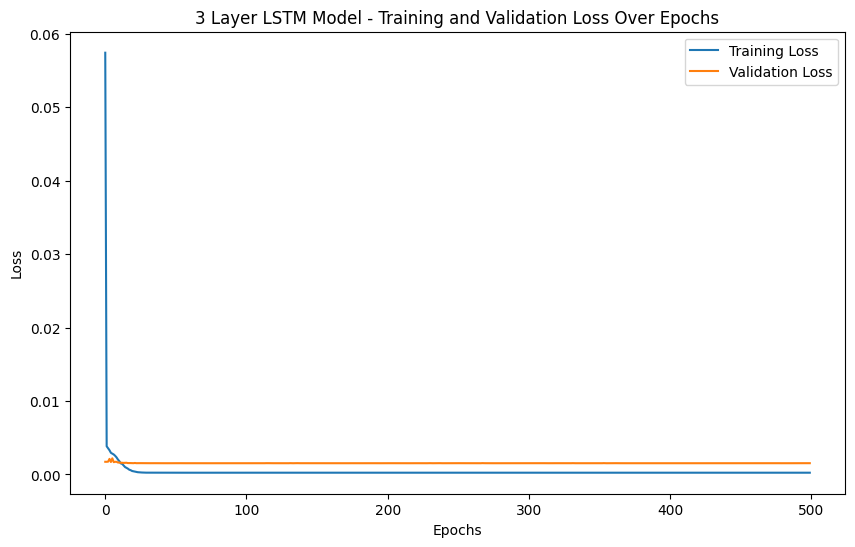

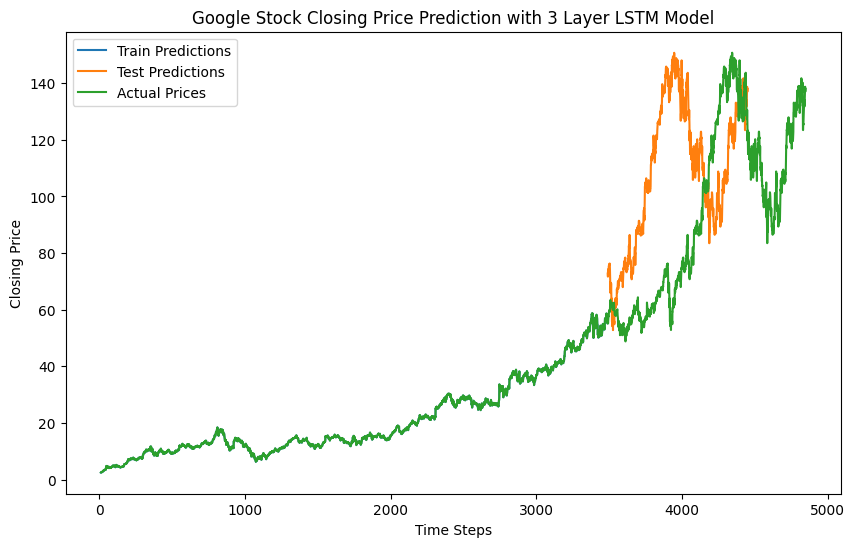

In [134]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building 3 Layer LSTM Model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Step 5: Training the Model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('3 Layer LSTM Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions and actual prices
plt.figure(figsize=(10, 6))
plt.title('Google Stock Closing Price Prediction with 3 Layer LSTM Model')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')
test_pred_range = np.arange(len(train_predictions) + time_steps, len(prices))
plt.plot(test_pred_range[:len(test_predictions)], test_predictions, label='Test Predictions')
actual_price_range = np.arange(time_steps, len(prices))
plt.plot(actual_price_range, prices[time_steps:], label='Actual Prices')
plt.legend()
plt.show()

1 Layer GRU Model

30/30 [==============================] - 0s 2ms/step
Train RMSE: 0.02
Test RMSE: 0.05
Train MAE: 0.02
Test MAE: 0.03
Train MAPE: 0.15%
Test MAPE: 0.03%


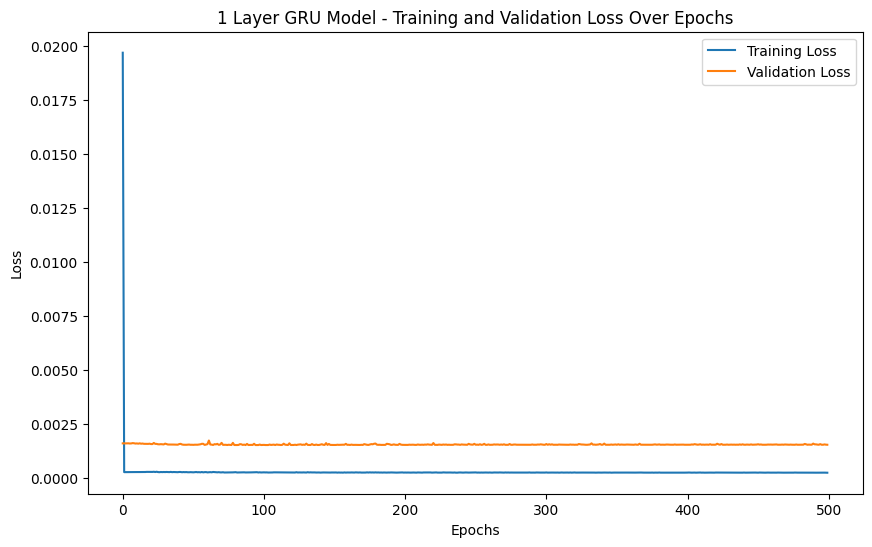

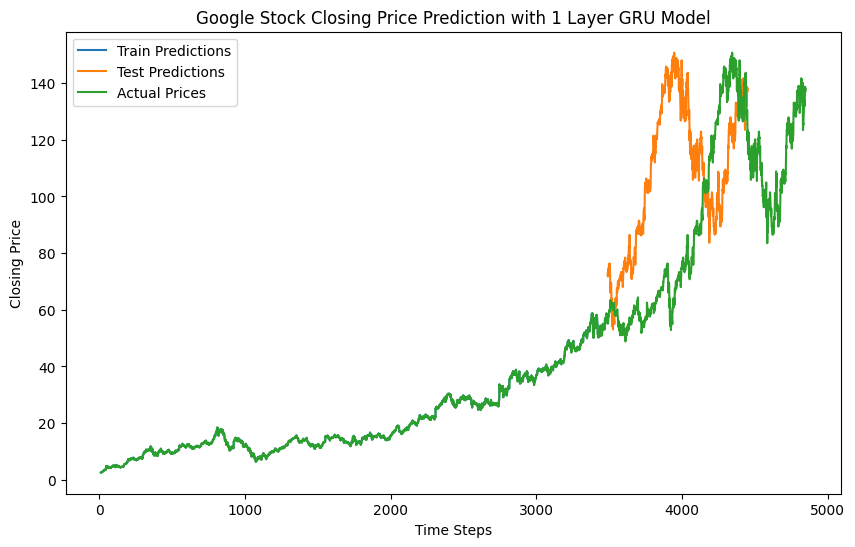

In [135]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building the 1 Layer GRU Model
model = Sequential()
model.add(GRU(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('1 Layer GRU Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions and actual prices
plt.figure(figsize=(10, 6))
plt.title('Google Stock Closing Price Prediction with 1 Layer GRU Model')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')
test_pred_range = np.arange(len(train_predictions) + time_steps, len(prices))
plt.plot(test_pred_range[:len(test_predictions)], test_predictions, label='Test Predictions')
actual_price_range = np.arange(time_steps, len(prices))
plt.plot(actual_price_range, prices[time_steps:], label='Actual Prices')
plt.legend()
plt.show()

2 Layer GRU Model

30/30 [==============================] - 0s 2ms/step
Train RMSE: 0.03
Test RMSE: 0.03
Train MAE: 0.03
Test MAE: 0.03
Train MAPE: 0.20%
Test MAPE: 0.03%


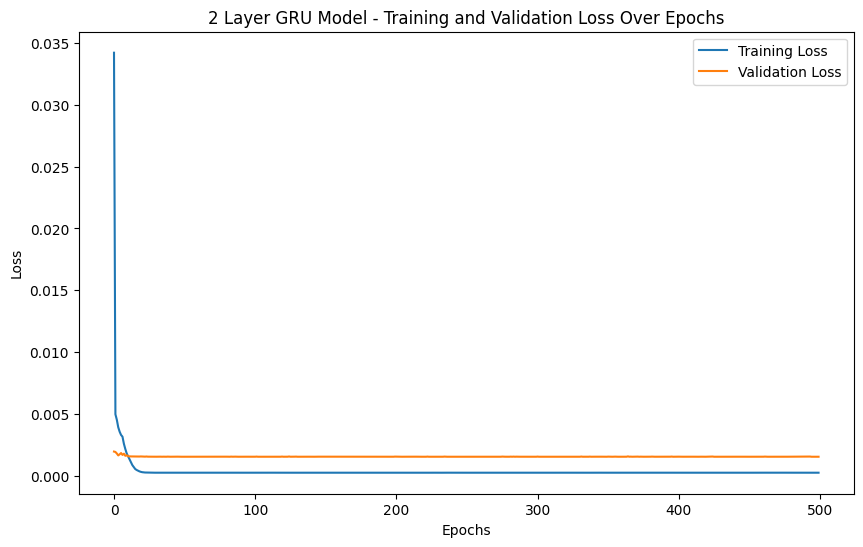

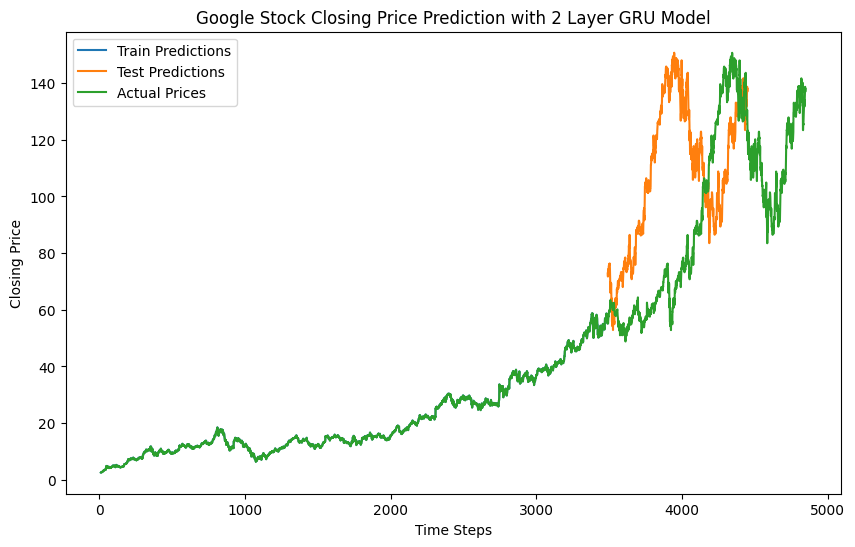

In [136]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building 2 Layer GRU Model
model = Sequential()
model.add(GRU(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('2 Layer GRU Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions and actual prices
plt.figure(figsize=(10, 6))
plt.title('Google Stock Closing Price Prediction with 2 Layer GRU Model')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')
test_pred_range = np.arange(len(train_predictions) + time_steps, len(prices))
plt.plot(test_pred_range[:len(test_predictions)], test_predictions, label='Test Predictions')
actual_price_range = np.arange(time_steps, len(prices))
plt.plot(actual_price_range, prices[time_steps:], label='Actual Prices')
plt.legend()
plt.show()

3 Layer GRU Model

30/30 [==============================] - 0s 2ms/step
Train RMSE: 0.01
Test RMSE: 0.01
Train MAE: 0.01
Test MAE: 0.01
Train MAPE: 0.06%
Test MAPE: 0.01%


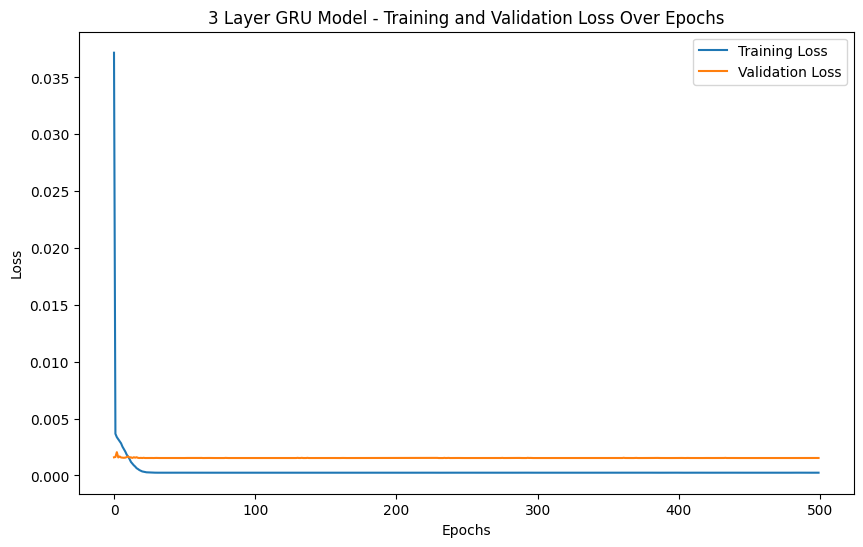

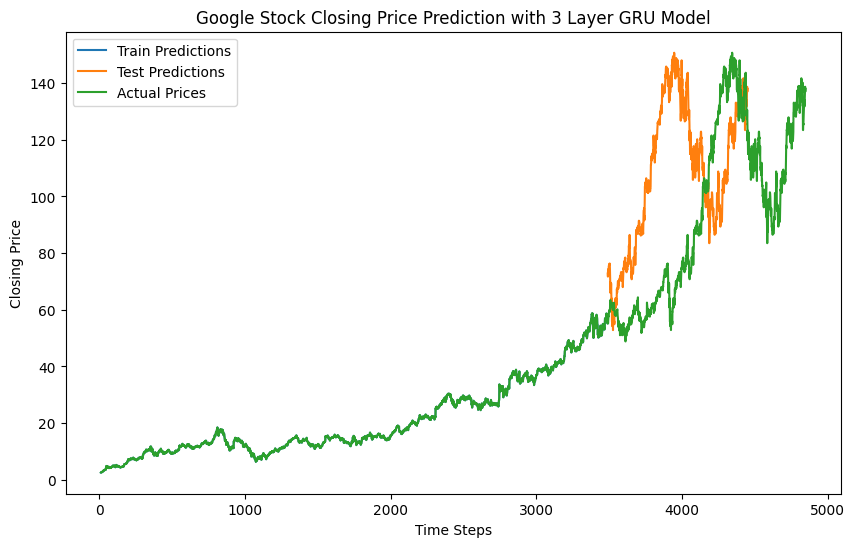

In [137]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building 3 Layer GRU Model
model = Sequential()
model.add(GRU(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50, activation='relu', return_sequences=True))
model.add(GRU(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('3 Layer GRU Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions and actual prices
plt.figure(figsize=(10, 6))
plt.title('Google Stock Closing Price Prediction with 3 Layer GRU Model')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')
test_pred_range = np.arange(len(train_predictions) + time_steps, len(prices))
plt.plot(test_pred_range[:len(test_predictions)], test_predictions, label='Test Predictions')
actual_price_range = np.arange(time_steps, len(prices))
plt.plot(actual_price_range, prices[time_steps:], label='Actual Prices')
plt.legend()
plt.show()

CHANGE FROM HERE DOWN

2 Layer LSTM - GRU Model

30/30 [==============================] - 0s 2ms/step
Train RMSE: 0.06
Test RMSE: 0.06
Train MAE: 0.06
Test MAE: 0.06
Train MAPE: 0.42%
Test MAPE: 0.06%


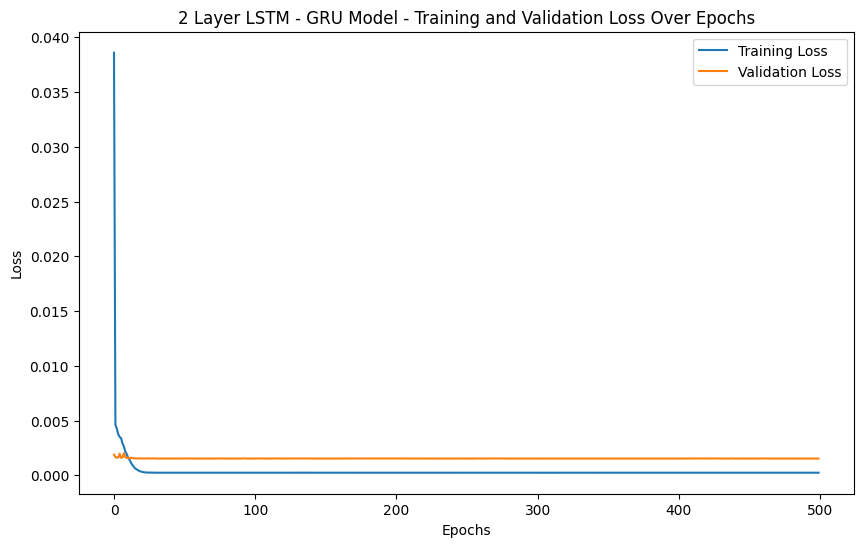

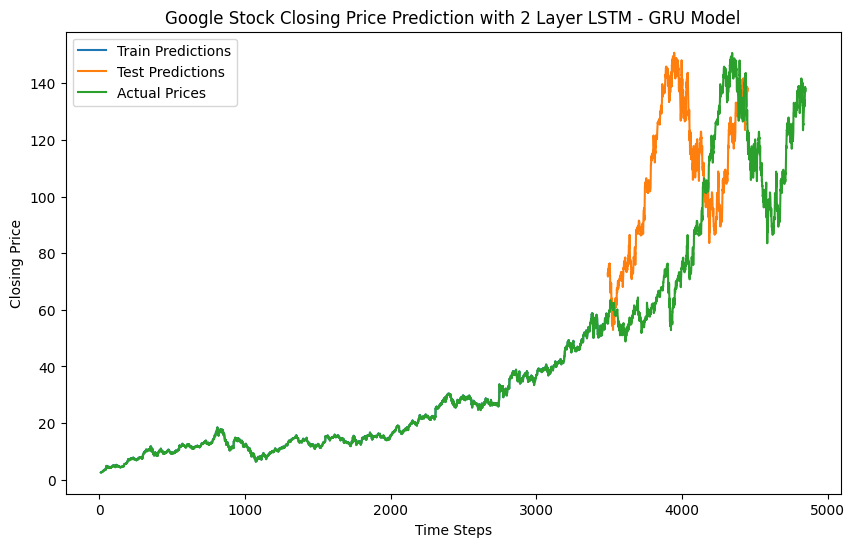

In [138]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building 2 Layer LSTM - GRU Model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('2 Layer LSTM - GRU Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions and actual prices
plt.figure(figsize=(10, 6))
plt.title('Google Stock Closing Price Prediction with 2 Layer LSTM - GRU Model')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')
test_pred_range = np.arange(len(train_predictions) + time_steps, len(prices))
plt.plot(test_pred_range[:len(test_predictions)], test_predictions, label='Test Predictions')
actual_price_range = np.arange(time_steps, len(prices))
plt.plot(actual_price_range, prices[time_steps:], label='Actual Prices')
plt.legend()
plt.show()

2 Layer GRU - LSTM Model

30/30 [==============================] - 0s 2ms/step
Train RMSE: 0.01
Test RMSE: 0.02
Train MAE: 0.01
Test MAE: 0.01
Train MAPE: 0.10%
Test MAPE: 0.01%


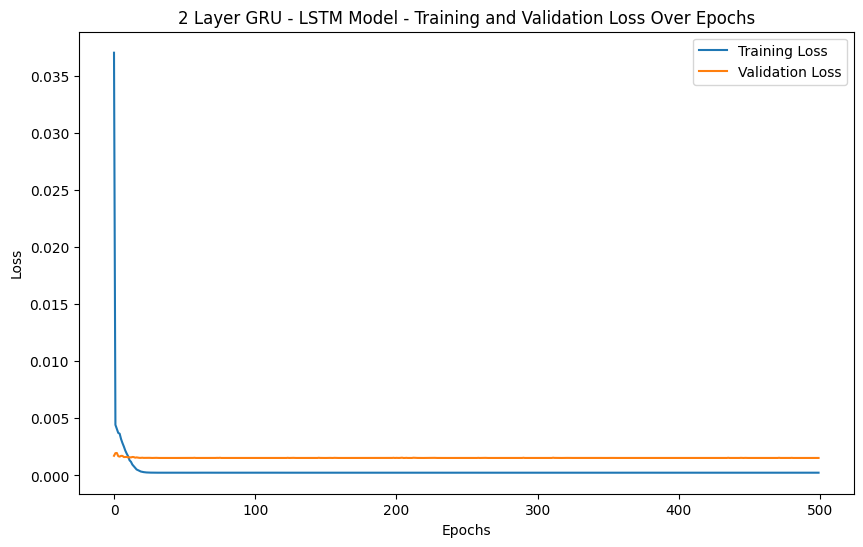

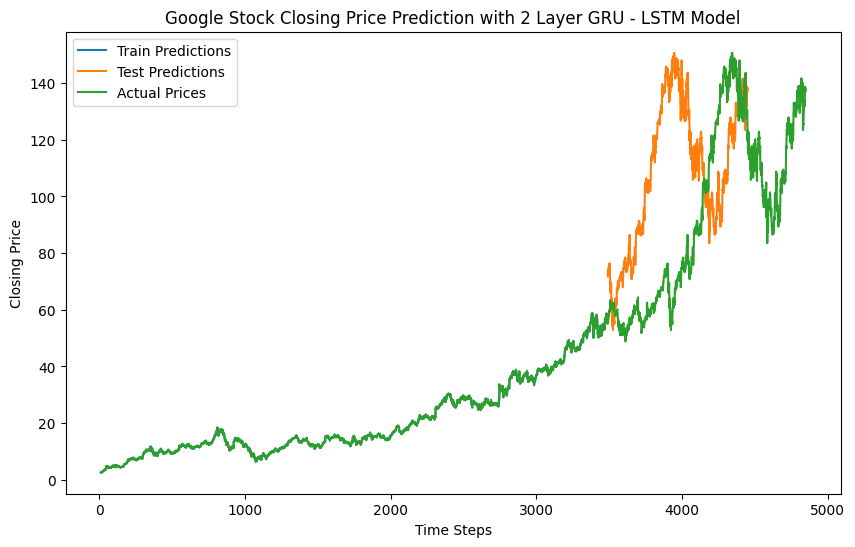

In [139]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building 2 Layer GRU - LSTM Model
model = Sequential()
model.add(GRU(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('2 Layer GRU - LSTM Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions and actual prices
plt.figure(figsize=(10, 6))
plt.title('Google Stock Closing Price Prediction with 2 Layer GRU - LSTM Model')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')
test_pred_range = np.arange(len(train_predictions) + time_steps, len(prices))
plt.plot(test_pred_range[:len(test_predictions)], test_predictions, label='Test Predictions')
actual_price_range = np.arange(time_steps, len(prices))
plt.plot(actual_price_range, prices[time_steps:], label='Actual Prices')
plt.legend()
plt.show()

Hyperparameter Tuning for 3 Layer GRU Model

12/12 [==============================] - 1s 3ms/step
Best Hyperparameters:
Units: 10
Activation: relu
Learning Rate: 0.001
Epochs: 50
Batch Size: 32


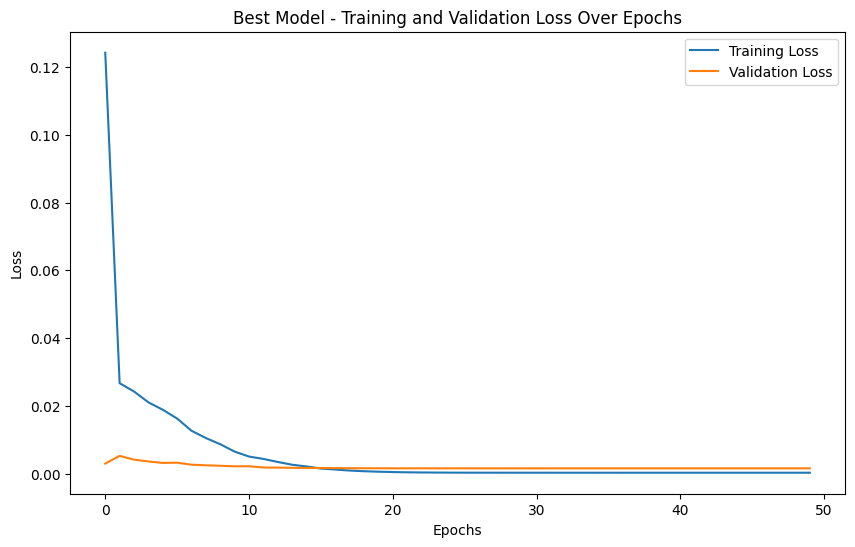

In [140]:
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

def hyperparameter_tuning(X_train, y_train, X_val, y_val, param_grid):

    # Generate all combinations of hyperparameters
    all_params = list(itertools.product(*param_grid.values()))

    best_params = None
    best_rmse = float('inf')
    best_model = None
    history = None

    for params in all_params:
        # Create and compile the model with the current set of hyperparameters       
        model = Sequential()
        model.add(GRU(units=params[0], activation=params[1], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(GRU(units=params[0], activation=params[1], return_sequences=True))
        model.add(GRU(units=params[0], activation=params[1]))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
        model.compile(optimizer=Adam(learning_rate=params[2]), loss='mean_squared_error')

        # Train the model
        current_history = model.fit(X_train, y_train, epochs=params[3], batch_size=params[4], validation_data=(X_val, y_val), verbose=0)

        # Evaluate the model on the validation set
        val_predictions = model.predict(X_val)
        val_predictions = prices[time_steps:len(val_predictions) + time_steps] + scaler.inverse_transform(val_predictions.reshape(-1, 1))
        val_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(val_predictions) + time_steps], val_predictions))

        # Update best parameters if the current model performs better
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_params = params
            best_model = model
            history = current_history

    return best_params, best_model, history

# Define the hyperparameter grid
param_grid = {
    'units': [10, 50, 100],
    'activation': ['relu'],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [10, 50, 100],
    'batch_size': [16, 32, 64]
}

# Perform hyperparameter tuning
best_params, best_model, history = hyperparameter_tuning(X_train, y_train, X_val, y_val, param_grid)

# Print the best hyperparameters
print("Best Hyperparameters:")
print("Units:", best_params[0])
print("Activation:", best_params[1])
print("Learning Rate:", best_params[2])
print("Epochs:", best_params[3])
print("Batch Size:", best_params[4])

# Visualize the training and validation loss of the best model
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Best Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

3 Layer GRU Model with Best Hyperparameters

30/30 [==============================] - 0s 2ms/step
Train RMSE: 0.01
Test RMSE: 0.02
Train MAE: 0.01
Test MAE: 0.01
Train MAPE: 0.04%
Test MAPE: 0.01%


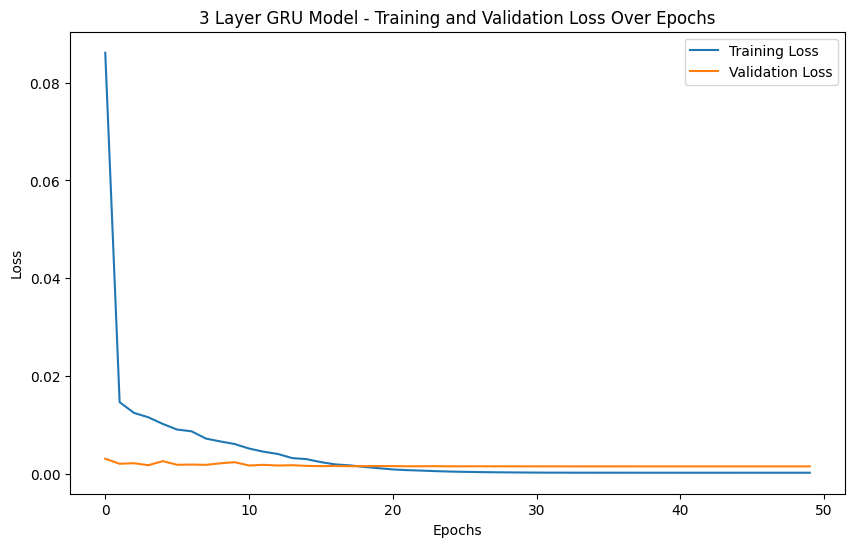

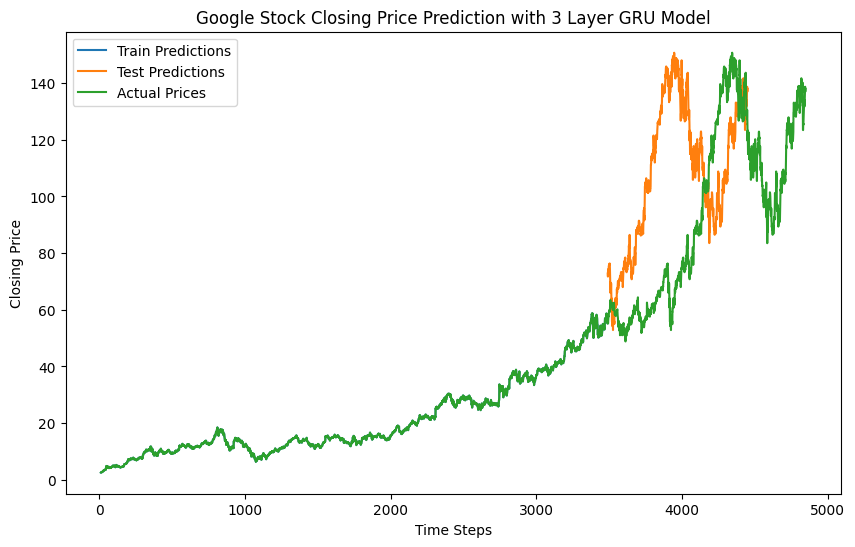

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building 3 Layer GRU Model
model = Sequential()
model.add(GRU(units=10, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=10, activation='relu', return_sequences=True))
model.add(GRU(units=10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('3 Layer GRU Model - Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions and actual prices
plt.figure(figsize=(10, 6))
plt.title('Google Stock Closing Price Prediction with 3 Layer GRU Model')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')
test_pred_range = np.arange(len(train_predictions) + time_steps, len(prices))
plt.plot(test_pred_range[:len(test_predictions)], test_predictions, label='Test Predictions')
actual_price_range = np.arange(time_steps, len(prices))
plt.plot(actual_price_range, prices[time_steps:], label='Actual Prices')
plt.legend()
plt.show()

Forecasting using the Final Model

30/30 [==============================] - 0s 2ms/step
Train RMSE: 0.03
Test RMSE: 0.03
Train MAE: 0.03
Test MAE: 0.03
Train MAPE: 0.19%
Test MAPE: 0.03%
1/1 [==============================] - 0s 19ms/step
2023-11-21: $137.95


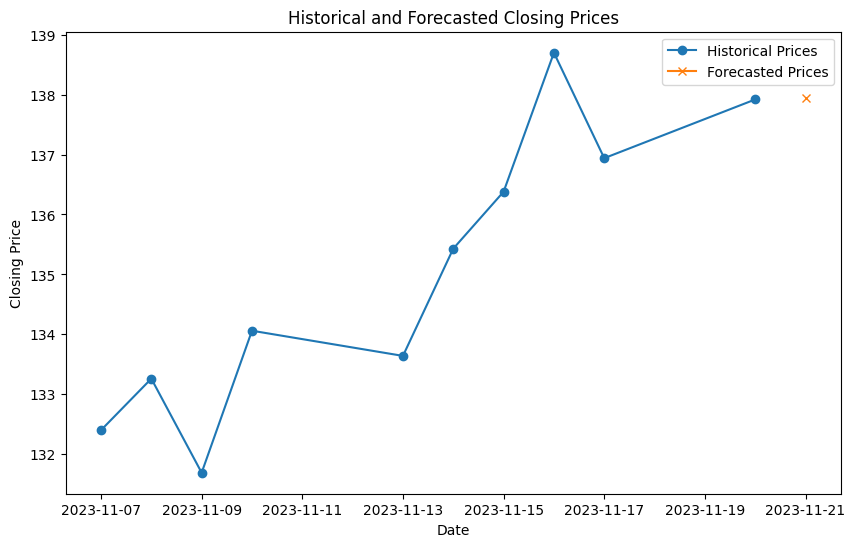

In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import datetime

# Data Collection
df = pd.read_csv("GOOG.csv")

# Correct the date format
df['Date'] = pd.to_datetime(df['Date'])

# Remove NaN values
df = df.dropna()

# Extract the 'Close' prices
prices = df['Close'].values.reshape(-1, 1)

# Calculate residuals (differences between consecutive prices)
residuals = np.diff(prices, axis=0)

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.reshape(-1, 1))

# Time Series Split
train_size = int(len(scaled_residuals) * 0.80)
train_data, test_data = scaled_residuals[0:train_size, :], scaled_residuals[train_size:len(scaled_residuals), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 10

# Split the data into training, validation, and test sets
val_size = int(len(train_data) * 0.1)
X_train, y_train = create_dataset(train_data[:-val_size], time_steps)
X_val, y_val = create_dataset(train_data[-val_size:], time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building 3 Layer GRU Model
model = Sequential()
model.add(GRU(units=10, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=10, activation='relu', return_sequences=True))
model.add(GRU(units=10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Model Evaluation
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
train_predictions = prices[time_steps:len(train_predictions) + time_steps] + scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = prices[-len(test_predictions):] + scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Evaluation Metrics
train_rmse = np.sqrt(mean_squared_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions))
test_rmse = np.sqrt(mean_squared_error(prices[-len(test_predictions):], test_predictions))

train_mae = mean_absolute_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mae = mean_absolute_error(prices[-len(test_predictions):], test_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(prices[time_steps:len(train_predictions) + time_steps], train_predictions)
test_mape = mean_absolute_percentage_error(prices[-len(test_predictions):], test_predictions)

# Print the evaluation metrics
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MAPE: {train_mape:.2f}%')
print(f'Test MAPE: {test_mape:.2f}%')

# Visualization

# Forecasting using the final model
forecast_days = 1
forecasted_prices = []
recent_data = prices[-time_steps:]

# Collect historical data for the past week
historical_dates = df['Date'].values[-time_steps:]
historical_prices = prices[-time_steps:]

for day in range(forecast_days):
    input_sequence = np.array(recent_data[-time_steps:]).reshape(1, -1)
    normalized_input = scaler.transform(input_sequence.reshape(-1, 1))
    input_for_model = normalized_input.reshape(1, 1, time_steps)
    predicted_residual = model.predict(input_for_model)
    predicted_price = prices[-1] + scaler.inverse_transform(predicted_residual.reshape(-1, 1))
    forecasted_prices.append(predicted_price[0, 0])
    recent_data = np.append(recent_data, predicted_price, axis=0)

# Display the forecasted closing prices for the upcoming week
start_date = df['Date'].max() + datetime.timedelta(days=1)
forecast_dates = [start_date + datetime.timedelta(days=i) for i in range(forecast_days)]

for date, price in zip(forecast_dates, forecasted_prices):
    print(f'{date.strftime("%Y-%m-%d")}: ${price:.2f}')

# Plot historical and forecasted prices
plt.figure(figsize=(10, 6))
plt.plot(historical_dates, historical_prices, label='Historical Prices', marker='o')
plt.plot(forecast_dates, forecasted_prices, label='Forecasted Prices', marker='x')
plt.title('Historical and Forecasted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()